In [10]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [11]:
IMG_HEIGHT, IMG_WIDTH = 64,64
BATCH_SIZE = 32
EPOCHS = 20
IMAGE_DIR = "../datasets/dataset2/face_crop"
MASK_DIR = "../datasets/dataset2/face_crop_segmentation"
NUM_IMAGES = 1000

In [12]:
# Load images and masks
def load_data(image_dir, mask_dir, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    count = 0
    for img_file, mask_file in zip(image_files, mask_files):
        if(count>=NUM_IMAGES):
            break
        # Read and resize images
        img = cv2.imread(os.path.join(image_dir, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, img_size) / 255.0  # Normalize

        # Read and resize masks
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        mask = mask / 255.0  # Convert to binary (0 or 1)

        images.append(img)
        masks.append(mask)
        count+=1
    return np.array(images), np.array(masks)

# Load dataset
X, Y = load_data(IMAGE_DIR, MASK_DIR)
print(f"Dataset loaded: {X.shape}, {Y.shape}")

Dataset loaded: (1000, 64, 64, 3), (1000, 64, 64, 1)


In [ ]:
# Split dataset (80% Train, 20% Validation)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=0)

# Define U-Net Model
def unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-7)

def dice_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)

# Compile Model
model = unet()
model.compile(optimizer=Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=[iou_metric,dice_metric])

# Train Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

# Save Model
# model.save("unet_mask_segmentation.h5")

Epoch 1/20
25/25 [==============================] - 47s 2s/step - loss: 0.9024 - iou_metric: 0.0365 - dice_metric: 0.0552 - val_loss: 0.6374 - val_iou_metric: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 2/20
25/25 [==============================] - 43s 2s/step - loss: 0.4713 - iou_metric: 0.2378 - dice_metric: 0.3098 - val_loss: 0.3539 - val_iou_metric: 0.5966 - val_dice_metric: 0.7472
Epoch 3/20
25/25 [==============================] - 46s 2s/step - loss: 0.3337 - iou_metric: 0.6307 - dice_metric: 0.7724 - val_loss: 0.2651 - val_iou_metric: 0.6940 - val_dice_metric: 0.8193
Epoch 4/20
25/25 [==============================] - 47s 2s/step - loss: 0.2788 - iou_metric: 0.7000 - dice_metric: 0.8233 - val_loss: 0.2526 - val_iou_metric: 0.7103 - val_dice_metric: 0.8306
Epoch 5/20
25/25 [==============================] - 45s 2s/step - loss: 0.2625 - iou_metric: 0.7067 - dice_metric: 0.8278 - val_loss: 0.2655 - val_iou_metric: 0.7221 - val_dice_metric: 0.8385
Epoch 6/20
25/25 [==============

1/1 [==============================] - 1s 582ms/step


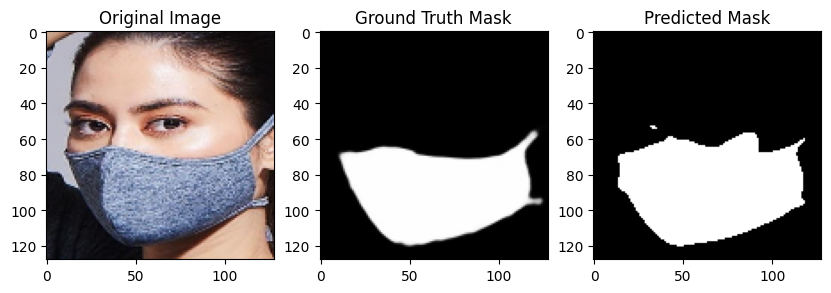

In [ ]:
# Evaluate Model
def predict_sample(model, X_val, Y_val, index=70):
    pred_mask = model.predict(np.expand_dims(X_val[index], axis=0))[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Thresholding

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[index])
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(Y_val[index].squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    plt.show()

# Test model on a sample image
predict_sample(model, X_val, Y_val)

In [ ]:
def calculate_iou(y_true, y_pred, threshold=0.5):
    # Ensure inputs are binary
    if y_true.dtype != np.bool_:
        y_true = y_true.astype(bool)

    if y_pred.dtype != np.bool_:
        y_pred = (y_pred > threshold).astype(bool)

    # Calculate intersection and union
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    # Handle edge case of empty masks
    if union == 0:
        return 1.0  # Both masks are empty, perfect match

    return intersection / union

def calculate_dice(y_true, y_pred, threshold=0.5):
    # Ensure inputs are binary
    if y_true.dtype != np.bool_:
        y_true = y_true.astype(bool)

    if y_pred.dtype != np.bool_:
        y_pred = (y_pred > threshold).astype(bool)

    # Calculate dice coefficient: 2*|X∩Y|/(|X|+|Y|)
    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()

    # Handle edge case of empty masks
    if total == 0:
        return 1.0  # Both masks are empty, perfect match

    return 2 * intersection / total

# Predict on validation set
y_preds = model.predict(X_val)

# Compute IoU for each image
iou_scores = []
dice_scores = []
for i in range(len(Y_val)):
    iou = calculate_iou(Y_val[i], y_preds[i])
    dice = calculate_dice(Y_val[i], y_preds[i])
    iou_scores.append(iou)
    dice_scores.append(dice)
    # print(f"Image {i+1}: IoU = {iou:.4f}")
    # print(f"Image {i+1}: Dice = {dice:.4f}")

# Compute Mean IoU
mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)
print(f"\nMean IoU on Validation Set: {mean_iou:.4f}")
print(f"\nMean Dice on Validation Set: {mean_dice:.4f}")

5/5 [==============================] - 7s 1s/step

Mean IoU on Validation Set: 0.7110

Mean Dice on Validation Set: 0.8235
